<a href="https://colab.research.google.com/github/Sammii0207/sami/blob/main/INFO5731_Assignment_Three_fall2022_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Three**

In this assignment, you are required to conduct information extraction, semantic analysis based on **the dataset you collected from assignment two**. You may use scipy and numpy package in this assignment.

# **Question 1: Understand N-gram**

(45 points). Write a python program to conduct N-gram analysis based on the dataset in your assignment two:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the **noun phrases** and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets). 


In [ ]:
# Write your code here
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv('amazon_reviews.csv')

df['tokens'] = df['Review Text'].apply(word_tokenize)

# Count trigrams and bigrams
df['trigrams'] = df['tokens'].apply(lambda x: Counter(nltk.ngrams(x, 3)))
df['bigrams'] = df['tokens'].apply(lambda x: Counter(nltk.ngrams(x, 2)))

def calculate_bigram_probabilities(bigram_counter, token_counter):
    return {bg: bg_count/token_counter[bg[0]] for bg, bg_count in bigram_counter.items()}

df['bigram_probabilities'] = df.apply(lambda row: calculate_bigram_probabilities(row['bigrams'], Counter(row['tokens'])), axis=1)

# Extract noun phrases
grammar = r'NP: {<DT>?<JJ>*<NN>}'
chunk_parser = nltk.RegexpParser(grammar)

def extract_noun_phrases(tokens):
    tagged_tokens = nltk.pos_tag(tokens)
    tree = chunk_parser.parse(tagged_tokens)
    return [' '.join(word for word, tag in subtree.leaves()) for subtree in tree.subtrees() if subtree.label() == 'NP']

df['noun_phrases'] = df['tokens'].apply(extract_noun_phrases)

noun_phrase_counter = Counter()
for np_list in df['noun_phrases']:
    noun_phrase_counter.update(np_list)

def calculate_noun_phrase_probabilities(np_list):
    np_counter = Counter(np_list)
    max_np_freq = max(noun_phrase_counter.values())
    return {np: np_counter[np]/max_np_freq for np in np_counter}

df['noun_phrase_probabilities'] = df['noun_phrases'].apply(calculate_noun_phrase_probabilities)

# Pivot the noun phrase probabilities into a DataFrame
df_noun_phrase_probabilities = pd.concat([df[['Review Text']], df['noun_phrase_probabilities'].apply(pd.Series)], axis=1)
df_noun_phrase_probabilities = df_noun_phrase_probabilities.melt(id_vars=['Review Text'], var_name='noun_phrase', value_name='probability')
df_noun_phrase_probabilities = df_noun_phrase_probabilities.pivot(index='Review Text', columns='noun_phrase', values='probability')

print(df_noun_phrase_probabilities)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


noun_phrase                                                %        -G  \
Review Text                                                              
A friend of mine recently gave me an echo. 2nd ...       NaN       NaN   
Bear with me...It all started with me wanting a...       NaN       NaN   
Bought this to control my lights and fan in an ...       NaN       NaN   
I bought 2 of these as refurbished, to add to t...       NaN       NaN   
I have 8 Echos in various rooms and from severa...       NaN  0.055556   
I have had homepod mini, the original homepod, ...       NaN       NaN   
I have my apartment which is not a small apartm...       NaN       NaN   
Small speaker with great clear sound. I’m not a...  0.055556       NaN   
The new Echo 4th Gen is a big change in aesthet...       NaN       NaN   
This is an honest review and comparison of the ...  0.055556       NaN   

noun_phrase                                         -Kitchen   -Picard  \
Review Text                          

# **Question 2: Undersand TF-IDF and Document representation**

(20 points). Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program: 

(1) To build the **documents-terms weights (tf*idf) matrix bold text**.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using **cosine similarity**.

In [ ]:
#I have used reviews that I extracted in assignment 2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

documents = [
    "Bear with me,It all started with me wanting a doorbell camera.  Ring had the number one rating, but it was too complicated, Ala carte parts.  I didn't know what parts I actually needed I just wanted a doorbell camera and a way to view from the indoors or from my phone. Blink made it simple. And combined with the Echo Show I got the two devices at a nice price. Now if I had stopped there... Lol... But no. I was so pleased with the echo show that I purchased the full-sized Echo speaker in the lighter blue for my bedroom.  This device came with the offer of a free smart bulb. The smart bulb worked great. And I could have stopped there... But no..I bought a large black  one for the kitchen. And a navy blue and a black dot for other rooms in the house.  I took advantage of the free smart bulb which with each of these Echo devices as well.Again I could have stopped there... But no.I expanded the blink system by buying the sync device which won't arrive till after Christmas and the mini camera.I purchased another set of smart bulbs. To expand my lighting system. I'm not even going to say I'm done. I'm sure I will think of another way of giving Amazon more of my money.  LolFYI, the Sengled brand bulbs are easy to set up.  5 star.  I purchased a set of Cree bulbs that were very difficult to set up and one of them unsynced itself within 24 hours and I had to set it up again. It's been over a week and they're still functioning so I'm keeping them but I would not buy Cree brand again  Overall all of the echo products work perfectly. Very easy to set up. The Alexa app allowed me to move some things around to set up different rooms and different groups. Alexa app is extremely easy to add or remove devices or change them from group to group just think it out logically. I was not able to get Google home to work as efficiently or as integrated so how it goes",
    "I have 8 Echos in various rooms and from several generations. Yep, I have a big house... What attracted me to this generation was that onboard voice capabilities that makes response faster and sure, who doesnâ€™t want even better sound quality? I also liked the design better than the looks of the previous generations and that I could see the activity â€˜light ringâ€™ when I was sitting down. The spherical designed has some real advantages and itâ€™s apparent in the improved sound. And improved it is. Music is easily better, more complex and effortless. This is NOT supposed to be a blast the neighborhood out speaker, but it did fill a larger room with quality sounding music that is noticeably improved to past generations. Voice commands and responses are practically instant and tigger happy quickly improved... Me likes so much that I replaced 2 of my 8 for in the areas where I am most using them. I even returned my first gen to amazon to get 25$ off then new one. Understand, my old ones are in pristine condition with all the original packaging and boxes, but how great to be able to do this!My whole house is voice controlled, lighting, fireplaces (ceramic logs with LED â€˜fake fire lightsâ€™), thermostat and as an early adopter of the Echo Voice Assistant, Iâ€™ve never looked back. Being able to ask any question, to ask about a stores hours before even driving there to make sure itâ€™s open and then being given the option to phone DIRECTLY from the device, is sweet. And how about NEVER having to touch your alarm clock to hit snooze or turn it off again? Yes please. Get quick and accurate local weather reports instantly, air quality too! Need to be reminded, multiple timers or announcements and intercom functions. Just say the word. I have every news channel I want set in my flash briefing and LOVE these, hearing them most days. Hereâ€™s my line up:  Daily scripture, this day in history, Fox news, BBC news, Management tip of the day and a few more. You can easily add what YOU want to hear and itâ€™s a treat. I LOVE podcasts and thereâ€™s a series called â€œHardcore Historyâ€ with hundred of episodes. Some of which are 6 hours long! Whatâ€™s cool is I can start one of these while Iâ€™m cooking in the kitchen, tell the device to stop when Iâ€™m finished and when I later (day, month, weeks or whatever) tell it to â€œPlay Hardcore Historyâ€ it will name the episode I left off on and pick it up for exactly the same spot! How sweet that??And guys, knock yourselves out because there are thousands of podcasts on virtually any subjects to enjoy and learn from. I love having this ability!!! LOVE, Love, love the ability to always be learning new things from this device while still doing what I do do in the background. Thereâ€™s so much more and I could literally go on for hours with what a great enhancement this has been in so many ways, learning, security, information, entertainment, news, communications, etc. Being able to have my arms full, walk though my house and just TEll a light to turn on along the way without having to touch or find a switch is sublime!  Yep, you need the right lights, but boy, talk about convenience and living in the future now. NEVER going back!  Even my landscaping lights and sprinkler control system, my security cameras works with it. And if I want to make an announcement to the whole house, I just say, â€œEcho, repeat EVERYWHEREâ€ and then tell it what I want to say. And all 8, in every room will go off: â€œDinner is in 5 minutes!â€ So sweet!I also have 2 of the Echo Clocks that work with the device and they are awesome. The LED ring and countdown before the alarm going off is sweet.But guys, I even LOVE just telling the Echo to play rain/storm sound effects and itâ€™s calming, deep and healing. What a wonderful, effortless device with so many capabilities. Even during one of my personal bible studies, I can ask Echo for some background on virtually anyone I reading about and background is forthcoming.Yes, I was an early adopter and man, these are a purchase Iâ€™ve never regretted making. I use them EVERY day and they have enhanced my life in ways that are special, rich and convenient. Like something out of a Dick Tracy comic from the 1930â€™s, this system is here, ripe, mature and developed. Iâ€™m such a fan!The only suggestion I have for Amazon would be to give me the option in a metal package. Who wants to dust fabric? Lastly, IF you built in even great Biblical knowledge capability, youâ€™d sell even millions more. Give me a teaching assistant that has a data base to field just about anything biblical I could ask of it.LOVING this product and the direction itâ€™s going. The future IS now and ECHO is the best, most supported, device with thousands and thousands of functions. Thank you Amazon and keep enhancing this baby because Iâ€™m upgrading all along the way. I returned on for a discount and the other 1st gen is going to a charity raffle. And heck, itâ€™s in perfect condition with all the original packaging and boxes.Hot Dog!-G",
    "A friend of mine recently gave me an echo. 2nd Gen. And I didn't think I was going to wind up using it very much but being visually impaired I wound up using it a lot more than I expected.I came to find out that I could listen to my audible books and also my kindle books read to me which is great for my visual impairment it makes it a lot more enjoyable during the day when I become bored with trying to figure out what is actually on the television with my provision some things are just not watchable like they used to be.But the echo. 2nd Gen. Speakers are well they leave a lot to be desired and I had to add additional speakers so when I saw this item I was like I'm gonna go see what the reviews are like and everyone said they were awesome they're awesome and so much better than the. 2nd Gen. So I decided to go ahead and get one for my birthday as a gift to myself and additionally I got the battery and the silicone carry case combination to go with it and I can take the thing all over my house in my yard and that is so cool.Since I've gotten this particular one though I have found there are so many other things that I can do with it other than just listen to my audio books and kindle books I can listen to podcasts I can get the daily news I can check the temperature in the room that the echo is in it is in which is really cool because I don't have an interior thermostat in my house I run on a space here and a wood stove so I never know what the interior temperature of my house is but I do now.There are also cool games you can play play I've been playing prices right and Trivia and a choose your own adventure kind of game andAre you smarter than a 5th grader by the way I'm smarter than a 5th grader.I opted in for Amazon music and not only am I finding all the songs that I've forgotten from my past but I found some really cool new ones things things that I would have never found without this echo.I've created playlists that when I'm in the mood for one thing or another I just tell she who cannot be named what playlist I want to hear and all of a sudden there I am.She can also actuate my televisionI have a roku TV but I have also added a fireStick as well and she can actuate both of them and also my easy buzz camera that I have to keep an eye on my front porch and yard and be able to speak to people out there when I have guests without going to the door.Being visually impaired this thing is a real helping hand the only thing would be better is if she could clean my house maybe Amazon will get there eventually.But for now I'm very fond of this deviceOther cool additional thingsI like how much bass the speaker has I like to listen to binaural beats music and meditation music and some dance music for exercise and I can feel the music it's pretty cool.The speaker is pretty darn decent.I chose the white version because because white is a color that I can see better with my vision the only concern I have is that the speaker cover might eventually get dirty but they get dirty I try to dust it on a daily basis just to make sure.We also are using it for well-to-do list for one, alarms, oh and I've set a household network up where the smaller echo. that I was gifted is now in my kitchen and I can play them as a group oop or someone in my kitchen can drop in on me and ask me if I want dinner or if I'm busy and vice versa I can drop in on them as well well additionally I've set it up so I can tell it to make phone calls directly from my cell phone and works as a great speaker phone I've tested it out a few times and everybody says that they can hear me just fine and clear.By the way for a little fun ask her to Beam me up Scottie. Just be careful of the tribbles.",
    "I ordered one of these for travel in my car on long road trips with the grandkids. Mine was a option that I was quite impressed with. I was able to download some movies to play periodically on the trips and a few of the kids game for the younger grandkids. I liked the screen quality and size for viewing. I ordered another one for my 12 year old grand daughter (after liking the quality of mine) for Christmas. She previously had the kids amazon Fire which worked well when she was younger. This Fire option gives them a little more freedom and better viewing. The only drawback is the lack of ad free and the kids apps. I wish they would design an app for their Fire's that you could purchase (even yearly) to prevent the ads. They make it difficult for some of the kids to maneuver. The price was also good, I did get it with their sale.",
    "This is great for the purpose intended. It's not a full blown android tablet, so if that's what your looking for, better go get one of those. For doing Amazon related stuff and surfing the internet, all while feeding you Amazon marketing, it's great. I've had half a dozen over the years and for the money, they're great. They do slow down alot after a year or two, but if you wait till Christmas time, you can replace with a new model for about half the retail price. If your kids need a tablet and your hesitant to give them a several hundred dollar device, this is the ticket. It even plays games, only Amazon store games, but there's a decent selection. So, there's my opinion on them. I'll probably get another one next year to replace the one of the fire 8s that are still running strong but slow. The 10s are great. Hopefully a new model will come along soon."
]

query = "I have my apartment which is not a small apartment and it has a loft as well for my 12-year-old son so he has his own area heâ€™s getting to that age so anyway I had I think 5 echo dots and one echo show that had the visual screen for pictures and things like that but without a subwoofer or anything I was fine with the multi room music and I used it for that and basically also used it so I could just tell any of my echo dots or just basically when I open the door I would say Alexa Turn on my apartment!! Immediately all of my lights would come on and some of them are dimmed to a certain level which you can do in the settings on your Alexa app that most people have on their phones. I even have a couple lightbulbs that are multicolored so I have them set to green and red currently for Christmas!! So the lights all come on when I tell Alexa to do that including my living room TV as well. You can add numerous other items that are compatible with Alexa and/or SmartThings app and you name it. If you donâ€™t have something that is compatible or doesnâ€™t have Bluetooth or wifi etcâ€¦ as long as you use a plugin for that item you can at MINIMUM turn it off and on with your voice or touch screen on your phone or Alexa show and I bought 2 of these Echoes because my friends have one or more and it is a sphere. So even though itâ€™s twice as big as the echo dot, in the newer generations at least, they started out looking like a hockey puck which is still good and people have them still but I started using Alexa products just a couple years ago so, mine are all round balls that you can talk to and play music and control lights and cameras for security while home or check on your home while youâ€™re not there!!I bought 2 regular Echoes to replace 2 of the echo dots because they have 3 or 4 different speakers in each one!!! Crazy how much sound you get from the dot but the bigger one the regular echo, sounds like a huge floor speaker but itâ€™s just a ball and you can get black or white or blue and more so I got 2 of them to pair together for stereo sound and to my Samsung TV that has an Alexa app built into it. So I can rock out or get surround sound when paired with my TV and Soundbar Sub woofer which I donâ€™t use the soundbar anymore the echoes sounded better but I got them last month. They were 49.99 a piece!!! Thatâ€™s like half price and why I hadnâ€™t bought them before so for 100 bucks I have a completely wonderful set of speakers that you barely notice and they sound wonderful and you can buy them with a Studio speaker by Amazon or an Amazon Subwoofer bundled for even more awesome sound but I live in an apartment so I donâ€™t want to get kicked out!!! They act as a hub for all of your Amazon devices also so you donâ€™t need anything else but one echo honestly to run all of your lights just get the type of bulbs they suggest and they have bundles for those also and itâ€™s truly amazing what quality of sound and other things that they can do but I have already typed far toooooo much. Start with 1 even for listening to music over the holidays and add devices as you go. Thatâ€™s what I did and 2 years later I have it set up so weâ€™ll that I can talk to my son when heâ€™s at his Moms house on his echo and my echo here and thereâ€™s no need for buying him a cellphone!! Yet!!Thereâ€™s just so much I could say about what these things do for 50 bucks to get one of them is a steal because youâ€™re just keep adding things and finding different things like grocery list reminders and alarms. It helps you with many things you wouldnâ€™t even imagine.So now, when I open my door to my apartment, I have it set to where the lights automatically come on with my TV. I donâ€™t even have to talk. Itâ€™ll do that too so kudos to the designers of these things because they are very affordable and do so much.!!!"

vectorizer = TfidfVectorizer(stop_words='english')

tfidf_matrix = vectorizer.fit_transform(documents)

query_tfidf = vectorizer.transform([query])

cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()

document_scores = [(i, score) for i, score in enumerate(cosine_similarities)]
document_scores = sorted(document_scores, key=lambda x: x[1], reverse=True)

print("Ranked Documents:")
for i, score in document_scores:
    print(f"Document {i+1}: {documents[i]} (Cosine Similarity Score: {score:.2f})")


Ranked Documents:
Document 2: I have 8 Echos in various rooms and from several generations. Yep, I have a big house... What attracted me to this generation was that onboard voice capabilities that makes response faster and sure, who doesnâ€™t want even better sound quality? I also liked the design better than the looks of the previous generations and that I could see the activity â€˜light ringâ€™ when I was sitting down. The spherical designed has some real advantages and itâ€™s apparent in the improved sound. And improved it is. Music is easily better, more complex and effortless. This is NOT supposed to be a blast the neighborhood out speaker, but it did fill a larger room with quality sounding music that is noticeably improved to past generations. Voice commands and responses are practically instant and tigger happy quickly improved... Me likes so much that I replaced 2 of my 8 for in the areas where I am most using them. I even returned my first gen to amazon to get 25$ off then ne

# **Question 3: Create your own word embedding model**

(20 points). Use the data you collected for assignment two to build a word embedding model: 

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

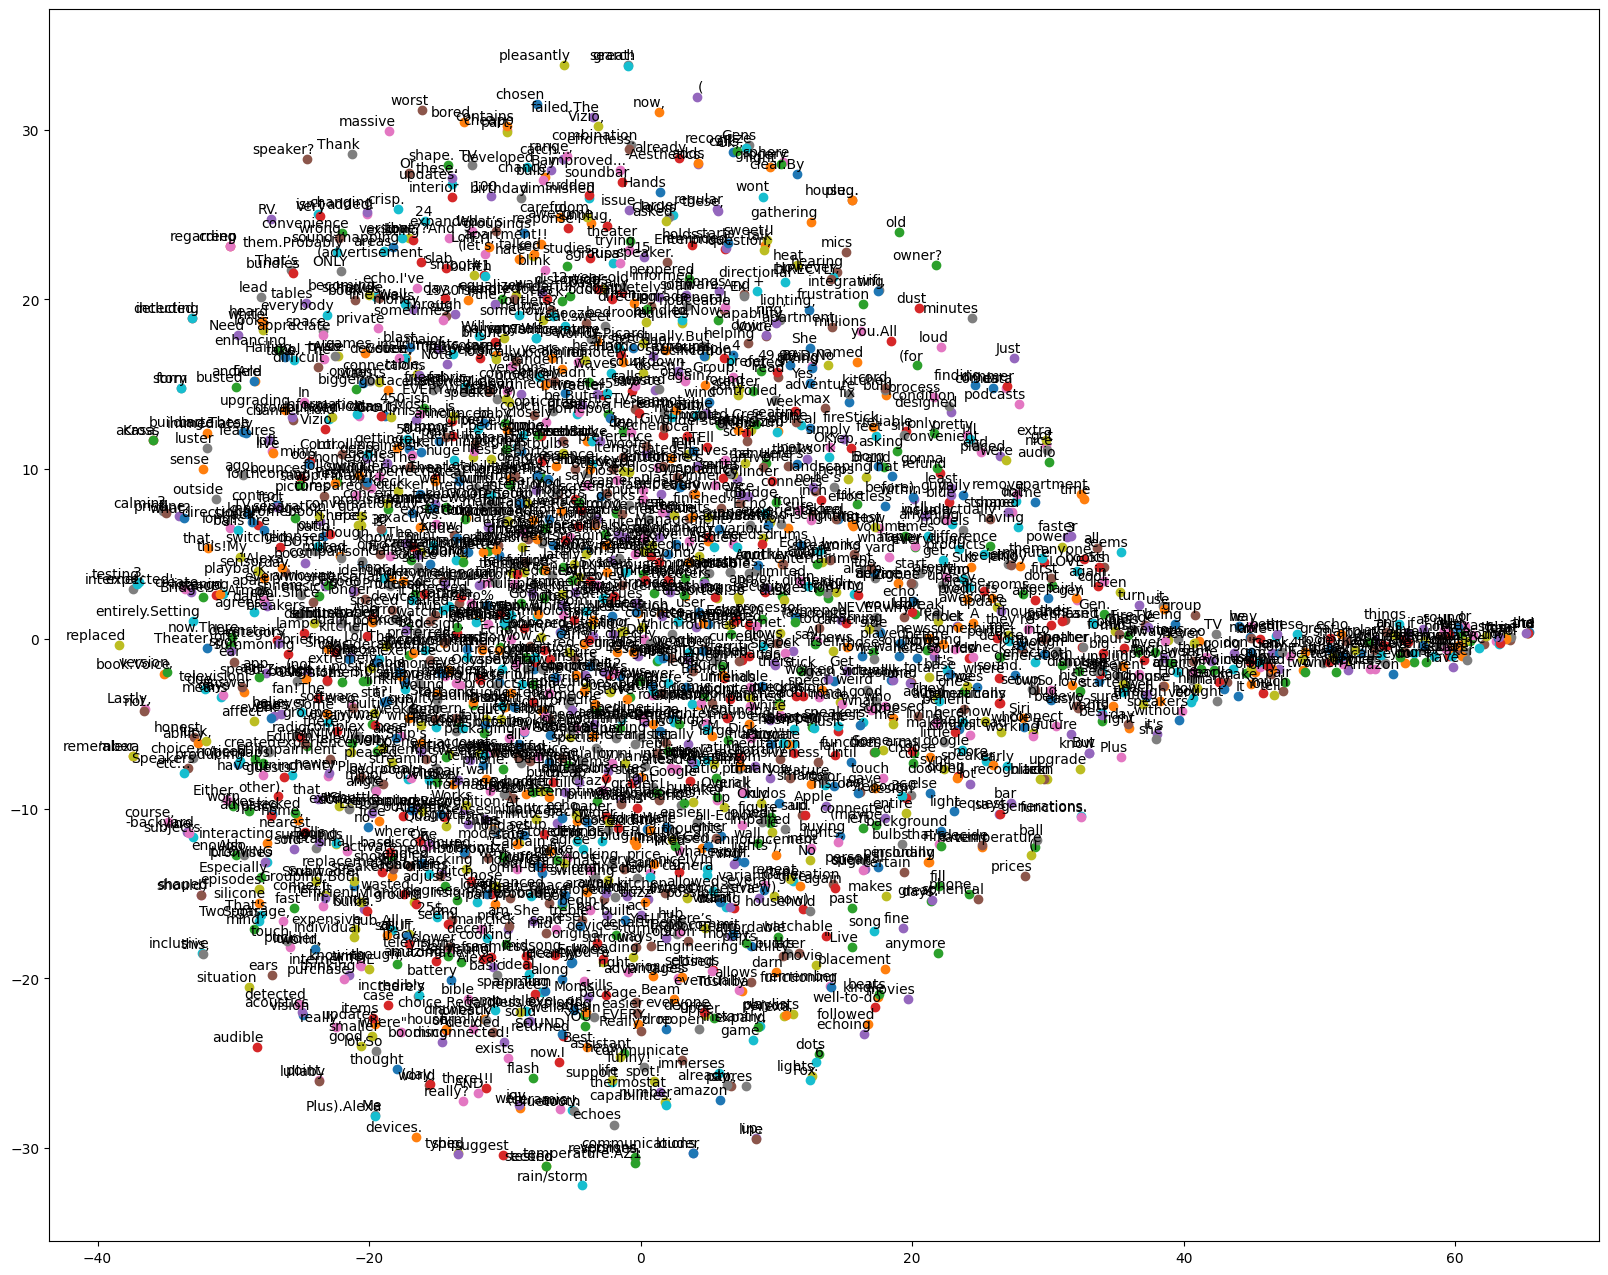

In [ ]:
# Write your code here
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import os.path

if not os.path.isfile("amazon_reviews.csv"):
    print("The file does not exist.")
else:
    reviews_df = pd.read_csv("amazon_reviews.csv")
    reviews = reviews_df["Review Text"].tolist()
    review_sentences = [review.split() for review in reviews]
    model = Word2Vec(sentences=review_sentences, vector_size=300, window=5, min_count=1, workers=4)
    model.save("word2vec.model")

    model = Word2Vec.load("word2vec.model")
    word_vectors = model.wv.vectors

    tsne = TSNE(n_components=2, random_state=0)
    word_vectors_2d = tsne.fit_transform(word_vectors)

    words = list(model.wv.key_to_index.keys())

    # Plot the 2-dimensional word embeddings
    plt.figure(figsize=(20, 16))
    for i, word in enumerate(words):
        x, y = word_vectors_2d[i, :]
        plt.scatter(x, y)
        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()


# **Question 4: Create your own training and evaluation data for sentiment analysis**

(15 points). **You dodn't need to write program for this question!** Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral). Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew. This datset will be used for assignment four: sentiment analysis and text classification. 


In [ ]:
# The GitHub link of your final csv file



# Link: "C:\Users\samiu\Downloads\annotated_amazon_reviews.csv"



